In [1]:
%matplotlib inline

import os
import time
import copy
import pickle
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import h5py
from tqdm.auto import tqdm, trange
import umap
from sampler import ImbalancedDatasetSampler
from ood_metrics import auroc, plot_roc, plot_barcode, calc_metrics, detection_error, fpr_at_95_tpr
import mc_uncertainty as mc

import torch
from torch.nn import functional as F
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import CIFAR10, CIFAR100, ImageFolder, SVHN
from torch import nn, optim
import torch.utils.data
import torchvision

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve


CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
FG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["automobile"]))
BG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["airplane", "cat", "bird", "deer", "frog", "dog", "horse", "ship", "truck"]))

NUM_CLASSES = 10
# INPUT_SIZE = 224
INPUT_SIZE = 32
BATCH_SIZE = 128
NUM_FEATURE_LAYERS = 31

RESULTS_FILE = 'mahal_llr.h5'

TRAIN = True

In [2]:
def create_model(kind='resnet152'):
    # Download pretrained model
    if kind == 'resnet152':
        model = models.resnet152(pretrained=True)
    elif kind == "densenet161":
        model = models.densenet161(pretrained=True)
    elif kind == "vgg16":
        model = models.vgg16(pretrained=True)
        
    # Freeze weights
    for param in model.parameters():
        param.requires_grad = False

    # Re-implement final classification layer
    if kind == 'resnet152':
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "densenet161":
        model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "vgg16":
        model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=NUM_CLASSES, bias=True)

    return model


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.target_transform(dataset.targets[idx])
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples
        


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, lr_scheduler=None, train_phase_name='train', val_phase_name='val'):
    since = time.time()

    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in trange(num_epochs, desc="Epochs"):
        tqdm.write('Epoch {}/{}'.format(epoch, num_epochs - 1))
        tqdm.write('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in [train_phase_name, val_phase_name]:
            if phase == train_phase_name:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], 
                                       total=len(dataloaders[phase]), 
                                       desc="{} batches".format(phase),
                                       leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_phase_name):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == train_phase_name:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            tqdm.write('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == val_phase_name and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == val_phase_name:
                val_loss = epoch_loss
                val_acc_history.append(epoch_acc)
            elif phase == train_phase_name:
                train_acc_history.append(epoch_acc)
                
        if lr_scheduler is not None:
            lr_scheduler.step(val_loss)
            
        tqdm.write("\n")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history


def save_model(model, path='model.pt'):
    torch.save(model.state_dict(), path)

    
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()


def plot_training_hist(train_hist, val_hist):
    thist = []
    vhist = []

    thist = [h.cpu().numpy() for h in train_hist]
    vhist = [h.cpu().numpy() for h in val_hist]

    plt.title("Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,NUM_EPOCHS+1),thist,label="Train")
    plt.plot(range(1,NUM_EPOCHS+1),vhist,label="Val")
    plt.legend()
    plt.show()
    
    
def save_history(train_hist, val_hist, train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'wb') as f:
        pickle.dump(train_hist, f)
    with open(val_hist_path, 'wb') as f:
        pickle.dump(val_hist, f)
        
        
def load_history(train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'rb') as f:
        train_hist = pickle.load(f)
    with open(val_hist_path, 'rb') as f:
        val_hist = pickle.load(f)
    return train_hist, val_hist


def evaluate_model(model, dataloader):
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader, total=len(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.detach().cpu().item()

# Implement a pretrained classifer and finetuning for CIFAR 10

## Set up data loaders

In [3]:
# Set up data loaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

def label_transform(y):
    if y in FG_CLASSES: return 0
    elif y in BG_CLASSES: return 1
    else: return 2

cifar10_train = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['train'])
cifar10_train_no_aug = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['val'])
cifar10_test = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=False, transform=data_transforms['val'])

cifar100_ood = CIFAR100('/media/tadenoud/DATADisk/datasets/cifar100/', train=False, transform=data_transforms['val'],
                       target_transform=lambda y: y+NUM_CLASSES)
imagenet_resize = ImageFolder('/media/tadenoud/DATADisk/datasets/tiny-imagenet-200/test', transform=data_transforms['val'],
                             target_transform=lambda y: y+NUM_CLASSES)
svhn_ood = SVHN('/media/tadenoud/DATADisk/datasets/svhn', split='test', transform=data_transforms['val'],
                target_transform=lambda y: y+NUM_CLASSES)


dataloaders_dict = {
    'train': torch.utils.data.DataLoader(cifar10_train, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True),
    'train_no_aug': torch.utils.data.DataLoader(cifar10_train_no_aug, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(cifar10_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'ood': torch.utils.data.DataLoader(cifar100_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'imagenet_resize': torch.utils.data.DataLoader(imagenet_resize, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'svhn': torch.utils.data.DataLoader(svhn_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = create_model("vgg16")
model = model.to(device)

## Define optimization objective, optimizer, etc

In [5]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


## Train and evaluate

Epoch 0/19
----------


train Loss: 1.5403 Acc: 0.4693


val Loss: 1.1877 Acc: 0.5863


Epoch 1/19
----------


train Loss: 1.4309 Acc: 0.5055


val Loss: 1.1451 Acc: 0.5971


Epoch 2/19
----------


train Loss: 1.4125 Acc: 0.5097


val Loss: 1.1247 Acc: 0.6066


Epoch 3/19
----------


train Loss: 1.4148 Acc: 0.5096


val Loss: 1.1292 Acc: 0.6040


Epoch 4/19
----------


train Loss: 1.3985 Acc: 0.5137


val Loss: 1.1360 Acc: 0.6017


Epoch 5/19
----------


train Loss: 1.3965 Acc: 0.5155


val Loss: 1.1380 Acc: 0.5978


Epoch 6/19
----------


train Loss: 1.3964 Acc: 0.5124


val Loss: 1.1364 Acc: 0.6042


Epoch 7/19
----------


train Loss: 1.3940 Acc: 0.5170


val Loss: 1.1132 Acc: 0.6114


Epoch 8/19
----------


train Loss: 1.3994 Acc: 0.5160


val Loss: 1.1182 Acc: 0.6111


Epoch 9/19
----------


train Loss: 1.3925 Acc: 0.5155


val Loss: 1.1088 Acc: 0.6110


Epoch 10/19
----------


train Loss: 1.3908 Acc: 0.5142


val Loss: 1.1052 Acc: 0.6175


Epoch 11/19
----------


train Loss: 1.3880 Acc: 0.5163


val Loss: 1.1382 Acc: 0.5981


Epoch 12/19
----------


train Loss: 1.3921 Acc: 0.5177


val Loss: 1.1186 Acc: 0.6057


Epoch 13/19
----------


train Loss: 1.3945 Acc: 0.5145


val Loss: 1.1174 Acc: 0.6132


Epoch 14/19
----------


train Loss: 1.3904 Acc: 0.5178


val Loss: 1.1089 Acc: 0.6088


Epoch 15/19
----------


train Loss: 1.3848 Acc: 0.5188


val Loss: 1.1254 Acc: 0.6056


Epoch 16/19
----------


train Loss: 1.3858 Acc: 0.5198


val Loss: 1.1187 Acc: 0.6097


Epoch 17/19
----------


train Loss: 1.3385 Acc: 0.5304


val Loss: 1.0805 Acc: 0.6210


Epoch 18/19
----------


train Loss: 1.3186 Acc: 0.5350


val Loss: 1.0752 Acc: 0.6263


Epoch 19/19
----------


train Loss: 1.3062 Acc: 0.5387


val Loss: 1.0753 Acc: 0.6248



Training complete in 4m 22s
Best val Acc: 0.626300


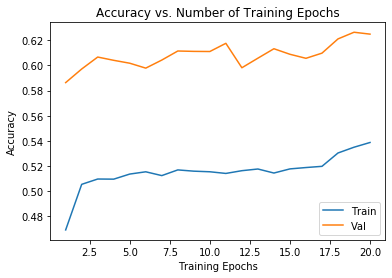

In [6]:
NUM_EPOCHS = 20
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(
        model, 
        dataloaders_dict, 
        criterion, 
        optimizer_ft, 
        num_epochs=NUM_EPOCHS,
        lr_scheduler=scheduler_ft)
    save_model(model, path='mahal_llr_1.pt')
    save_history(train_hist, val_hist, 'mahal_llr_1_train_hist.pickle', 'mahal_llr_1_val_hist.pickle')
else:
    load_model(model, path='mahal_llr_1.pt')
    train_hist, val_hist = load_history('mahal_llr_1_train_hist.pickle', 'mahal_llr_1_val_hist.pickle')

plot_training_hist(train_hist, val_hist)    

## Fine tune top convolutional layers

In [7]:
# print(model)

# Freeze weights
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze top layers
for param in model.features[23:].parameters():
    param.requires_grad = True
    
for param in model.classifier.parameters():
    param.requires_grad = True

In [8]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=1e-3, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


Epoch 0/99
----------


train Loss: 1.2001 Acc: 0.5767


val Loss: 0.8804 Acc: 0.6926


Epoch 1/99
----------


train Loss: 1.0531 Acc: 0.6286


val Loss: 0.7951 Acc: 0.7218


Epoch 2/99
----------


train Loss: 0.9880 Acc: 0.6524


val Loss: 0.7482 Acc: 0.7449


Epoch 3/99
----------


train Loss: 0.9493 Acc: 0.6657


val Loss: 0.7138 Acc: 0.7484


Epoch 4/99
----------


train Loss: 0.9161 Acc: 0.6786


val Loss: 0.6941 Acc: 0.7587


Epoch 5/99
----------


train Loss: 0.8902 Acc: 0.6885


val Loss: 0.6770 Acc: 0.7672


Epoch 6/99
----------


train Loss: 0.8555 Acc: 0.6987


val Loss: 0.6620 Acc: 0.7740


Epoch 7/99
----------


train Loss: 0.8496 Acc: 0.7006


val Loss: 0.6428 Acc: 0.7770


Epoch 8/99
----------


train Loss: 0.8322 Acc: 0.7066


val Loss: 0.6317 Acc: 0.7808


Epoch 9/99
----------


train Loss: 0.8141 Acc: 0.7159


val Loss: 0.6234 Acc: 0.7882


Epoch 10/99
----------


train Loss: 0.8132 Acc: 0.7155


val Loss: 0.6211 Acc: 0.7879


Epoch 11/99
----------


train Loss: 0.7989 Acc: 0.7191


val Loss: 0.6006 Acc: 0.7913


Epoch 12/99
----------


train Loss: 0.7885 Acc: 0.7234


val Loss: 0.5990 Acc: 0.7936


Epoch 13/99
----------


train Loss: 0.7806 Acc: 0.7249


val Loss: 0.6045 Acc: 0.7942


Epoch 14/99
----------


train Loss: 0.7682 Acc: 0.7297


val Loss: 0.5906 Acc: 0.7978


Epoch 15/99
----------


train Loss: 0.7615 Acc: 0.7325


val Loss: 0.5886 Acc: 0.7982


Epoch 16/99
----------


train Loss: 0.7574 Acc: 0.7350


val Loss: 0.5764 Acc: 0.8055


Epoch 17/99
----------


train Loss: 0.7487 Acc: 0.7375


val Loss: 0.5715 Acc: 0.8063


Epoch 18/99
----------


train Loss: 0.7446 Acc: 0.7374


val Loss: 0.5726 Acc: 0.8070


Epoch 19/99
----------


train Loss: 0.7309 Acc: 0.7442


val Loss: 0.5666 Acc: 0.8062


Epoch 20/99
----------


train Loss: 0.7311 Acc: 0.7449


val Loss: 0.5699 Acc: 0.8056


Epoch 21/99
----------


train Loss: 0.7226 Acc: 0.7449


val Loss: 0.5747 Acc: 0.8038


Epoch 22/99
----------


train Loss: 0.7129 Acc: 0.7504


val Loss: 0.5640 Acc: 0.8128


Epoch 23/99
----------


train Loss: 0.7098 Acc: 0.7506


val Loss: 0.5733 Acc: 0.8059


Epoch 24/99
----------


train Loss: 0.7098 Acc: 0.7504


val Loss: 0.5546 Acc: 0.8094


Epoch 25/99
----------


train Loss: 0.7027 Acc: 0.7530


val Loss: 0.5609 Acc: 0.8074


Epoch 26/99
----------


train Loss: 0.6989 Acc: 0.7557


val Loss: 0.5575 Acc: 0.8122


Epoch 27/99
----------


train Loss: 0.6885 Acc: 0.7587


val Loss: 0.5569 Acc: 0.8126


Epoch 28/99
----------


train Loss: 0.6871 Acc: 0.7579


val Loss: 0.5417 Acc: 0.8159


Epoch 29/99
----------


train Loss: 0.6887 Acc: 0.7568


val Loss: 0.5464 Acc: 0.8118


Epoch 30/99
----------


train Loss: 0.6818 Acc: 0.7590


val Loss: 0.5503 Acc: 0.8153


Epoch 31/99
----------


train Loss: 0.6786 Acc: 0.7613


val Loss: 0.5421 Acc: 0.8134


Epoch 32/99
----------


train Loss: 0.6684 Acc: 0.7674


val Loss: 0.5572 Acc: 0.8101


Epoch 33/99
----------


train Loss: 0.6706 Acc: 0.7663


val Loss: 0.5483 Acc: 0.8166


Epoch 34/99
----------


train Loss: 0.6611 Acc: 0.7672


val Loss: 0.5495 Acc: 0.8166


Epoch 35/99
----------


train Loss: 0.6491 Acc: 0.7722


val Loss: 0.5360 Acc: 0.8191


Epoch 36/99
----------


train Loss: 0.6403 Acc: 0.7734


val Loss: 0.5317 Acc: 0.8205


Epoch 37/99
----------


train Loss: 0.6371 Acc: 0.7762


val Loss: 0.5291 Acc: 0.8219


Epoch 38/99
----------


train Loss: 0.6381 Acc: 0.7771


val Loss: 0.5305 Acc: 0.8227


Epoch 39/99
----------


train Loss: 0.6348 Acc: 0.7749


val Loss: 0.5312 Acc: 0.8225


Epoch 40/99
----------


train Loss: 0.6247 Acc: 0.7812


val Loss: 0.5318 Acc: 0.8219


Epoch 41/99
----------


train Loss: 0.6291 Acc: 0.7785


val Loss: 0.5285 Acc: 0.8227


Epoch 42/99
----------


train Loss: 0.6298 Acc: 0.7795


val Loss: 0.5317 Acc: 0.8230


Epoch 43/99
----------


train Loss: 0.6341 Acc: 0.7756


val Loss: 0.5297 Acc: 0.8211


Epoch 44/99
----------


train Loss: 0.6346 Acc: 0.7763


val Loss: 0.5259 Acc: 0.8224


Epoch 45/99
----------


train Loss: 0.6249 Acc: 0.7787


val Loss: 0.5279 Acc: 0.8213


Epoch 46/99
----------


train Loss: 0.6229 Acc: 0.7818


val Loss: 0.5303 Acc: 0.8224


Epoch 47/99
----------


train Loss: 0.6274 Acc: 0.7774


val Loss: 0.5283 Acc: 0.8202


Epoch 48/99
----------


train Loss: 0.6219 Acc: 0.7821


val Loss: 0.5252 Acc: 0.8211


Epoch 49/99
----------


train Loss: 0.6280 Acc: 0.7789


val Loss: 0.5292 Acc: 0.8226


Epoch 50/99
----------


train Loss: 0.6189 Acc: 0.7823


val Loss: 0.5281 Acc: 0.8208


Epoch 51/99
----------


train Loss: 0.6189 Acc: 0.7812


val Loss: 0.5295 Acc: 0.8228


Epoch 52/99
----------


train Loss: 0.6198 Acc: 0.7835


val Loss: 0.5300 Acc: 0.8218


Epoch 53/99
----------


train Loss: 0.6224 Acc: 0.7812


val Loss: 0.5293 Acc: 0.8209


Epoch 54/99
----------


train Loss: 0.6177 Acc: 0.7815


val Loss: 0.5286 Acc: 0.8217


Epoch 55/99
----------


train Loss: 0.6126 Acc: 0.7856


val Loss: 0.5291 Acc: 0.8233


Epoch 56/99
----------


train Loss: 0.6171 Acc: 0.7830


val Loss: 0.5284 Acc: 0.8225


Epoch 57/99
----------


train Loss: 0.6203 Acc: 0.7809


val Loss: 0.5282 Acc: 0.8225


Epoch 58/99
----------


train Loss: 0.6129 Acc: 0.7834


val Loss: 0.5292 Acc: 0.8220


Epoch 59/99
----------


train Loss: 0.6170 Acc: 0.7815


val Loss: 0.5293 Acc: 0.8225


Epoch 60/99
----------


train Loss: 0.6175 Acc: 0.7829


val Loss: 0.5292 Acc: 0.8232


Epoch 61/99
----------


train Loss: 0.6244 Acc: 0.7801


val Loss: 0.5289 Acc: 0.8231


Epoch 62/99
----------


train Loss: 0.6171 Acc: 0.7823


val Loss: 0.5289 Acc: 0.8231


Epoch 63/99
----------


train Loss: 0.6156 Acc: 0.7847


val Loss: 0.5290 Acc: 0.8230


Epoch 64/99
----------


train Loss: 0.6160 Acc: 0.7829


val Loss: 0.5291 Acc: 0.8232


Epoch 65/99
----------


train Loss: 0.6199 Acc: 0.7843


val Loss: 0.5291 Acc: 0.8234


Epoch 66/99
----------


train Loss: 0.6152 Acc: 0.7842


val Loss: 0.5290 Acc: 0.8232


Epoch 67/99
----------


train Loss: 0.6208 Acc: 0.7828


val Loss: 0.5290 Acc: 0.8232


Epoch 68/99
----------


train Loss: 0.6179 Acc: 0.7822


val Loss: 0.5290 Acc: 0.8232


Epoch 69/99
----------


train Loss: 0.6134 Acc: 0.7831


val Loss: 0.5290 Acc: 0.8232


Epoch 70/99
----------


train Loss: 0.6193 Acc: 0.7820


val Loss: 0.5290 Acc: 0.8232


Epoch 71/99
----------


train Loss: 0.6251 Acc: 0.7809


val Loss: 0.5289 Acc: 0.8232


Epoch 72/99
----------


train Loss: 0.6191 Acc: 0.7820


val Loss: 0.5289 Acc: 0.8232


Epoch 73/99
----------


train Loss: 0.6158 Acc: 0.7830


val Loss: 0.5289 Acc: 0.8232


Epoch 74/99
----------


train Loss: 0.6109 Acc: 0.7841


val Loss: 0.5289 Acc: 0.8232


Epoch 75/99
----------


train Loss: 0.6169 Acc: 0.7827


val Loss: 0.5289 Acc: 0.8232


Epoch 76/99
----------


train Loss: 0.6163 Acc: 0.7855


val Loss: 0.5289 Acc: 0.8232


Epoch 77/99
----------


train Loss: 0.6124 Acc: 0.7856


val Loss: 0.5289 Acc: 0.8232


Epoch 78/99
----------


train Loss: 0.6207 Acc: 0.7813


val Loss: 0.5289 Acc: 0.8232


Epoch 79/99
----------


train Loss: 0.6203 Acc: 0.7792


val Loss: 0.5289 Acc: 0.8232


Epoch 80/99
----------


train Loss: 0.6167 Acc: 0.7819


val Loss: 0.5289 Acc: 0.8232


Epoch 81/99
----------


train Loss: 0.6147 Acc: 0.7835


val Loss: 0.5289 Acc: 0.8232


Epoch 82/99
----------


train Loss: 0.6143 Acc: 0.7839


val Loss: 0.5289 Acc: 0.8232


Epoch 83/99
----------


train Loss: 0.6192 Acc: 0.7808


val Loss: 0.5289 Acc: 0.8232


Epoch 84/99
----------


train Loss: 0.6247 Acc: 0.7811


val Loss: 0.5289 Acc: 0.8232


Epoch 85/99
----------


train Loss: 0.6130 Acc: 0.7833


val Loss: 0.5289 Acc: 0.8232


Epoch 86/99
----------


train Loss: 0.6186 Acc: 0.7820


val Loss: 0.5289 Acc: 0.8232


Epoch 87/99
----------


train Loss: 0.6165 Acc: 0.7832


val Loss: 0.5289 Acc: 0.8232


Epoch 88/99
----------


train Loss: 0.6169 Acc: 0.7850


val Loss: 0.5289 Acc: 0.8232


Epoch 89/99
----------


train Loss: 0.6179 Acc: 0.7814


val Loss: 0.5289 Acc: 0.8232


Epoch 90/99
----------


train Loss: 0.6161 Acc: 0.7843


val Loss: 0.5289 Acc: 0.8232


Epoch 91/99
----------


train Loss: 0.6103 Acc: 0.7848


val Loss: 0.5289 Acc: 0.8232


Epoch 92/99
----------


train Loss: 0.6204 Acc: 0.7794


val Loss: 0.5289 Acc: 0.8231


Epoch 93/99
----------


train Loss: 0.6182 Acc: 0.7830


val Loss: 0.5289 Acc: 0.8231


Epoch 94/99
----------


train Loss: 0.6132 Acc: 0.7843


val Loss: 0.5289 Acc: 0.8231


Epoch 95/99
----------


train Loss: 0.6142 Acc: 0.7847


val Loss: 0.5289 Acc: 0.8231


Epoch 96/99
----------


train Loss: 0.6095 Acc: 0.7870


val Loss: 0.5289 Acc: 0.8231


Epoch 97/99
----------


train Loss: 0.6229 Acc: 0.7792


val Loss: 0.5289 Acc: 0.8231


Epoch 98/99
----------


train Loss: 0.6205 Acc: 0.7834


val Loss: 0.5289 Acc: 0.8231


Epoch 99/99
----------


train Loss: 0.6140 Acc: 0.7843


val Loss: 0.5289 Acc: 0.8231



Training complete in 38m 29s
Best val Acc: 0.823400


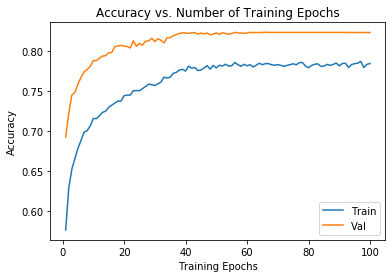

In [9]:
NUM_EPOCHS = 100
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(model, 
                                              dataloaders_dict, 
                                              criterion, 
                                              optimizer_ft, 
                                              num_epochs=NUM_EPOCHS,
                                              lr_scheduler=scheduler_ft)
    save_model(model, path='mahal_llr_1_fine.pt')
    save_history(train_hist, val_hist, 'mahal_llr_1_train_hist_fine.pickle', 'mahal_llr_1_val_hist_fine.pickle')
else:
    load_model(model, path='mahal_llr_1_fine.pt')
    train_hist, val_hist = load_history('mahal_llr_1_train_hist_fine.pickle', 'mahal_llr_1_val_hist_fine.pickle')

plot_training_hist(train_hist, val_hist)

In [10]:
print("Model accuracy:", evaluate_model(model, dataloaders_dict['val'])) 


Model accuracy: 0.8234


# Train a second classifer with input corruption

## Set up data loaders

In [11]:
from torch import distributions
torch.manual_seed(42)
from PIL import Image

BERNOULLI_MU = 0.2
IMG_SHAPE = (32, 32, 3)

    
class BernoulliPixelSwap(object):
    """
    Draws img_size samples from a Bernoulli distribution parameterized by mu.
    For each positive sample drawn, the corresponding pixel in the image the function
    is called on will be randomly assigned a value in [0,255] with equal probability.
    """
    def __init__(self, mu, img_shape):
        super().__init__()
        self.img_shape = img_shape
        self.bernoulli = distributions.Bernoulli(mu)
        self.multinomial = distributions.categorical.Categorical(torch.Tensor(list(range(256))))
        
    def __call__(self, img):
        mask = self.bernoulli.sample(self.img_shape).numpy().astype(np.bool)        
        values = self.multinomial.sample(self.img_shape).numpy()
        
        new_img = np.asarray(img).copy()
        new_img[mask] = values[mask]
        return Image.fromarray(new_img)
                                  
bernoulli_swap = BernoulliPixelSwap(BERNOULLI_MU, IMG_SHAPE)

In [12]:
# Set up data loaders
data_transforms['train_corruption'] = transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(bernoulli_swap),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

cifar10_train_corruption = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['train_corruption'])

dataloaders_dict['train_corruption'] = torch.utils.data.DataLoader(cifar10_train_corruption, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

In [13]:
model = create_model("vgg16")
model = model.to(device)

## Define optimization objective, optimizer, etc

In [14]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


## Train and evaluate

Epoch 0/19
----------


train_corruption Loss: 2.2404 Acc: 0.2415


val Loss: 2.0675 Acc: 0.2577


Epoch 1/19
----------


train_corruption Loss: 2.1801 Acc: 0.2556


val Loss: 1.9833 Acc: 0.2936


Epoch 2/19
----------


train_corruption Loss: 2.1685 Acc: 0.2570


val Loss: 1.9833 Acc: 0.2990


Epoch 3/19
----------


train_corruption Loss: 2.1614 Acc: 0.2596


val Loss: 1.9946 Acc: 0.2952


Epoch 4/19
----------


train_corruption Loss: 2.1623 Acc: 0.2625


val Loss: 1.9835 Acc: 0.2998


Epoch 5/19
----------


train_corruption Loss: 2.1587 Acc: 0.2633


val Loss: 1.9695 Acc: 0.2974


Epoch 6/19
----------


train_corruption Loss: 2.1511 Acc: 0.2666


val Loss: 1.9626 Acc: 0.2936


Epoch 7/19
----------


train_corruption Loss: 2.1646 Acc: 0.2625


val Loss: 1.9698 Acc: 0.3014


Epoch 8/19
----------


train_corruption Loss: 2.1551 Acc: 0.2628


val Loss: 1.9852 Acc: 0.3057


Epoch 9/19
----------


train_corruption Loss: 2.1475 Acc: 0.2635


val Loss: 2.0214 Acc: 0.2872


Epoch 10/19
----------


train_corruption Loss: 2.1545 Acc: 0.2657


val Loss: 1.9588 Acc: 0.3133


Epoch 11/19
----------


train_corruption Loss: 2.1606 Acc: 0.2645


val Loss: 1.9564 Acc: 0.3171


Epoch 12/19
----------


train_corruption Loss: 2.1567 Acc: 0.2686


val Loss: 1.9711 Acc: 0.3121


Epoch 13/19
----------


train_corruption Loss: 2.1525 Acc: 0.2654


val Loss: 1.9257 Acc: 0.3336


Epoch 14/19
----------


train_corruption Loss: 2.1607 Acc: 0.2655


val Loss: 1.9452 Acc: 0.3230


Epoch 15/19
----------


train_corruption Loss: 2.1510 Acc: 0.2667


val Loss: 1.9724 Acc: 0.3202


Epoch 16/19
----------


train_corruption Loss: 2.1539 Acc: 0.2659


val Loss: 1.9375 Acc: 0.3263


Epoch 17/19
----------


train_corruption Loss: 2.1619 Acc: 0.2621


val Loss: 1.9342 Acc: 0.3314


Epoch 18/19
----------


train_corruption Loss: 2.1483 Acc: 0.2671


val Loss: 1.9800 Acc: 0.3104


Epoch 19/19
----------


train_corruption Loss: 2.1559 Acc: 0.2684


val Loss: 1.9415 Acc: 0.3248



Training complete in 105m 52s
Best val Acc: 0.333600


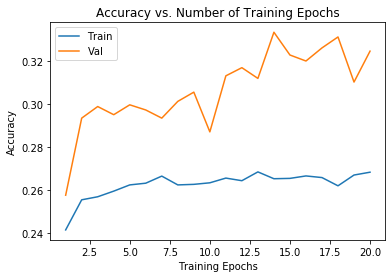

In [15]:
NUM_EPOCHS = 20
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(
        model, 
        dataloaders_dict, 
        criterion, 
        optimizer_ft, 
        num_epochs=NUM_EPOCHS,
        lr_scheduler=scheduler_ft,
        train_phase_name='train_corruption'
    )
    save_model(model, path='mahal_llr_2.pt')
    save_history(train_hist, val_hist, 'mahal_llr_2_train_hist.pickle', 'mahal_llr_2_val_hist.pickle')
else:
    load_model(model, path='mahal_llr_2.pt')
    train_hist, val_hist = load_history('mahal_llr_2_train_hist.pickle', 'mahal_llr_2_val_hist.pickle')

plot_training_hist(train_hist, val_hist)    

## Fine tune top convolutional layers

In [16]:
# print(model)

# Freeze weights
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze top layers
for param in model.features[23:].parameters():
    param.requires_grad = True
    
for param in model.classifier.parameters():
    param.requires_grad = True

In [17]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=1e-3, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


Epoch 0/99
----------


train_corruption Loss: 1.7974 Acc: 0.3446


val Loss: 1.8357 Acc: 0.3511


Epoch 1/99
----------


train_corruption Loss: 1.6865 Acc: 0.3887


val Loss: 1.7645 Acc: 0.3710


Epoch 2/99
----------


train_corruption Loss: 1.6344 Acc: 0.4074


val Loss: 1.7217 Acc: 0.3865


Epoch 3/99
----------


train_corruption Loss: 1.6025 Acc: 0.4206


val Loss: 1.6823 Acc: 0.3957


Epoch 4/99
----------


train_corruption Loss: 1.5747 Acc: 0.4312


val Loss: 1.6457 Acc: 0.4134


Epoch 5/99
----------


train_corruption Loss: 1.5621 Acc: 0.4383


val Loss: 1.6530 Acc: 0.4126


Epoch 6/99
----------


train_corruption Loss: 1.5471 Acc: 0.4448


val Loss: 1.5727 Acc: 0.4310


Epoch 7/99
----------


train_corruption Loss: 1.5285 Acc: 0.4533


val Loss: 1.5729 Acc: 0.4363


Epoch 8/99
----------


train_corruption Loss: 1.5169 Acc: 0.4547


val Loss: 1.5694 Acc: 0.4392


Epoch 9/99
----------


train_corruption Loss: 1.5076 Acc: 0.4597


val Loss: 1.5661 Acc: 0.4441


Epoch 10/99
----------


train_corruption Loss: 1.5006 Acc: 0.4626


val Loss: 1.5623 Acc: 0.4442


Epoch 11/99
----------


train_corruption Loss: 1.4839 Acc: 0.4659


val Loss: 1.5376 Acc: 0.4485


Epoch 12/99
----------


train_corruption Loss: 1.4806 Acc: 0.4704


val Loss: 1.5132 Acc: 0.4624


Epoch 13/99
----------


train_corruption Loss: 1.4799 Acc: 0.4706


val Loss: 1.5236 Acc: 0.4542


Epoch 14/99
----------


train_corruption Loss: 1.4727 Acc: 0.4743


val Loss: 1.5042 Acc: 0.4656


Epoch 15/99
----------


train_corruption Loss: 1.4601 Acc: 0.4764


val Loss: 1.5083 Acc: 0.4667


Epoch 16/99
----------


train_corruption Loss: 1.4587 Acc: 0.4753


val Loss: 1.5060 Acc: 0.4613


Epoch 17/99
----------


train_corruption Loss: 1.4529 Acc: 0.4797


val Loss: 1.4919 Acc: 0.4643


Epoch 18/99
----------


train_corruption Loss: 1.4456 Acc: 0.4823


val Loss: 1.4933 Acc: 0.4689


Epoch 19/99
----------


train_corruption Loss: 1.4408 Acc: 0.4832


val Loss: 1.4980 Acc: 0.4612


Epoch 20/99
----------


train_corruption Loss: 1.4434 Acc: 0.4848


val Loss: 1.4681 Acc: 0.4721


Epoch 21/99
----------


train_corruption Loss: 1.4379 Acc: 0.4868


val Loss: 1.4804 Acc: 0.4748


Epoch 22/99
----------


train_corruption Loss: 1.4326 Acc: 0.4896


val Loss: 1.4454 Acc: 0.4870


Epoch 23/99
----------


train_corruption Loss: 1.4304 Acc: 0.4888


val Loss: 1.4448 Acc: 0.4829


Epoch 24/99
----------


train_corruption Loss: 1.4213 Acc: 0.4932


val Loss: 1.4094 Acc: 0.4985


Epoch 25/99
----------


train_corruption Loss: 1.4234 Acc: 0.4930


val Loss: 1.4575 Acc: 0.4843


Epoch 26/99
----------


train_corruption Loss: 1.4109 Acc: 0.4977


val Loss: 1.4407 Acc: 0.4891


Epoch 27/99
----------


train_corruption Loss: 1.4079 Acc: 0.4974


val Loss: 1.4285 Acc: 0.4953


Epoch 28/99
----------


train_corruption Loss: 1.4118 Acc: 0.4988


val Loss: 1.4205 Acc: 0.4953


Epoch 29/99
----------


train_corruption Loss: 1.4042 Acc: 0.5004


val Loss: 1.4167 Acc: 0.4988


Epoch 30/99
----------


train_corruption Loss: 1.4072 Acc: 0.4974


val Loss: 1.4231 Acc: 0.4960


Epoch 31/99
----------


train_corruption Loss: 1.3809 Acc: 0.5067


val Loss: 1.4018 Acc: 0.5037


Epoch 32/99
----------


train_corruption Loss: 1.3813 Acc: 0.5087


val Loss: 1.3996 Acc: 0.5063


Epoch 33/99
----------


train_corruption Loss: 1.3742 Acc: 0.5108


val Loss: 1.3926 Acc: 0.5064


Epoch 34/99
----------


train_corruption Loss: 1.3752 Acc: 0.5105


val Loss: 1.3957 Acc: 0.5067


Epoch 35/99
----------


train_corruption Loss: 1.3690 Acc: 0.5114


val Loss: 1.3901 Acc: 0.5091


Epoch 36/99
----------


train_corruption Loss: 1.3690 Acc: 0.5121


val Loss: 1.3944 Acc: 0.5073


Epoch 37/99
----------


train_corruption Loss: 1.3626 Acc: 0.5152


val Loss: 1.3870 Acc: 0.5110


Epoch 38/99
----------


train_corruption Loss: 1.3631 Acc: 0.5169


val Loss: 1.3854 Acc: 0.5111


Epoch 39/99
----------


train_corruption Loss: 1.3629 Acc: 0.5132


val Loss: 1.3921 Acc: 0.5086


Epoch 40/99
----------


train_corruption Loss: 1.3664 Acc: 0.5124


val Loss: 1.3867 Acc: 0.5106


Epoch 41/99
----------


train_corruption Loss: 1.3623 Acc: 0.5150


val Loss: 1.3903 Acc: 0.5092


Epoch 42/99
----------


train_corruption Loss: 1.3720 Acc: 0.5095


val Loss: 1.3908 Acc: 0.5079


Epoch 43/99
----------


train_corruption Loss: 1.3671 Acc: 0.5120


val Loss: 1.3930 Acc: 0.5065


Epoch 44/99
----------


train_corruption Loss: 1.3592 Acc: 0.5146


val Loss: 1.3901 Acc: 0.5076


Epoch 45/99
----------


train_corruption Loss: 1.3606 Acc: 0.5128


val Loss: 1.3915 Acc: 0.5072


Epoch 46/99
----------


train_corruption Loss: 1.3668 Acc: 0.5136


val Loss: 1.3925 Acc: 0.5077


Epoch 47/99
----------


train_corruption Loss: 1.3592 Acc: 0.5156


val Loss: 1.3936 Acc: 0.5076


Epoch 48/99
----------


train_corruption Loss: 1.3547 Acc: 0.5176


val Loss: 1.3933 Acc: 0.5076


Epoch 49/99
----------


train_corruption Loss: 1.3654 Acc: 0.5147


val Loss: 1.3914 Acc: 0.5079


Epoch 50/99
----------


train_corruption Loss: 1.3614 Acc: 0.5169


val Loss: 1.3930 Acc: 0.5084


Epoch 51/99
----------


train_corruption Loss: 1.3490 Acc: 0.5207


val Loss: 1.3927 Acc: 0.5084


Epoch 52/99
----------


train_corruption Loss: 1.3630 Acc: 0.5155


val Loss: 1.3927 Acc: 0.5083


Epoch 53/99
----------


train_corruption Loss: 1.3531 Acc: 0.5169


val Loss: 1.3924 Acc: 0.5083


Epoch 54/99
----------


train_corruption Loss: 1.3639 Acc: 0.5154


val Loss: 1.3922 Acc: 0.5084


Epoch 55/99
----------


train_corruption Loss: 1.3559 Acc: 0.5175


val Loss: 1.3920 Acc: 0.5083


Epoch 56/99
----------


train_corruption Loss: 1.3557 Acc: 0.5147


val Loss: 1.3919 Acc: 0.5083


Epoch 57/99
----------


train_corruption Loss: 1.3540 Acc: 0.5175


val Loss: 1.3919 Acc: 0.5083


Epoch 58/99
----------


train_corruption Loss: 1.3582 Acc: 0.5172


val Loss: 1.3919 Acc: 0.5083


Epoch 59/99
----------


train_corruption Loss: 1.3652 Acc: 0.5126


val Loss: 1.3919 Acc: 0.5083


Epoch 60/99
----------


train_corruption Loss: 1.3572 Acc: 0.5151


val Loss: 1.3919 Acc: 0.5083


Epoch 61/99
----------


train_corruption Loss: 1.3618 Acc: 0.5156


val Loss: 1.3918 Acc: 0.5083


Epoch 62/99
----------


train_corruption Loss: 1.3620 Acc: 0.5140


val Loss: 1.3918 Acc: 0.5084


Epoch 63/99
----------


train_corruption Loss: 1.3592 Acc: 0.5175


val Loss: 1.3918 Acc: 0.5084


Epoch 64/99
----------


train_corruption Loss: 1.3617 Acc: 0.5127


val Loss: 1.3918 Acc: 0.5084


Epoch 65/99
----------


train_corruption Loss: 1.3592 Acc: 0.5154


val Loss: 1.3918 Acc: 0.5084


Epoch 66/99
----------


train_corruption Loss: 1.3606 Acc: 0.5132


val Loss: 1.3918 Acc: 0.5084


Epoch 67/99
----------


train_corruption Loss: 1.3601 Acc: 0.5152


val Loss: 1.3918 Acc: 0.5084


Epoch 68/99
----------


train_corruption Loss: 1.3516 Acc: 0.5191


val Loss: 1.3918 Acc: 0.5084


Epoch 69/99
----------


train_corruption Loss: 1.3533 Acc: 0.5165


val Loss: 1.3918 Acc: 0.5084


Epoch 70/99
----------


train_corruption Loss: 1.3585 Acc: 0.5156


val Loss: 1.3918 Acc: 0.5084


Epoch 71/99
----------


train_corruption Loss: 1.3569 Acc: 0.5164


val Loss: 1.3918 Acc: 0.5084


Epoch 72/99
----------


train_corruption Loss: 1.3668 Acc: 0.5125


val Loss: 1.3918 Acc: 0.5084


Epoch 73/99
----------


train_corruption Loss: 1.3650 Acc: 0.5129


val Loss: 1.3918 Acc: 0.5084


Epoch 74/99
----------


train_corruption Loss: 1.3536 Acc: 0.5168


val Loss: 1.3918 Acc: 0.5084


Epoch 75/99
----------


train_corruption Loss: 1.3615 Acc: 0.5151


val Loss: 1.3918 Acc: 0.5084


Epoch 76/99
----------


train_corruption Loss: 1.3524 Acc: 0.5196


val Loss: 1.3918 Acc: 0.5084


Epoch 77/99
----------


train_corruption Loss: 1.3636 Acc: 0.5135


val Loss: 1.3918 Acc: 0.5084


Epoch 78/99
----------


train_corruption Loss: 1.3625 Acc: 0.5134


val Loss: 1.3918 Acc: 0.5083


Epoch 79/99
----------


train_corruption Loss: 1.3611 Acc: 0.5149


val Loss: 1.3918 Acc: 0.5083


Epoch 80/99
----------


train_corruption Loss: 1.3521 Acc: 0.5167


val Loss: 1.3918 Acc: 0.5084


Epoch 81/99
----------


train_corruption Loss: 1.3561 Acc: 0.5169


val Loss: 1.3918 Acc: 0.5083


Epoch 82/99
----------


train_corruption Loss: 1.3606 Acc: 0.5148


val Loss: 1.3918 Acc: 0.5083


Epoch 83/99
----------


train_corruption Loss: 1.3630 Acc: 0.5119


val Loss: 1.3918 Acc: 0.5084


Epoch 84/99
----------


train_corruption Loss: 1.3611 Acc: 0.5128


val Loss: 1.3918 Acc: 0.5084


Epoch 85/99
----------


train_corruption Loss: 1.3614 Acc: 0.5166


val Loss: 1.3918 Acc: 0.5084


Epoch 86/99
----------


train_corruption Loss: 1.3507 Acc: 0.5214


val Loss: 1.3918 Acc: 0.5084


Epoch 87/99
----------


train_corruption Loss: 1.3581 Acc: 0.5179


val Loss: 1.3918 Acc: 0.5084


Epoch 88/99
----------


train_corruption Loss: 1.3588 Acc: 0.5157


val Loss: 1.3918 Acc: 0.5084


Epoch 89/99
----------


train_corruption Loss: 1.3634 Acc: 0.5152


val Loss: 1.3918 Acc: 0.5083


Epoch 90/99
----------


train_corruption Loss: 1.3491 Acc: 0.5209


val Loss: 1.3918 Acc: 0.5084


Epoch 91/99
----------


train_corruption Loss: 1.3568 Acc: 0.5177


val Loss: 1.3918 Acc: 0.5084


Epoch 92/99
----------


train_corruption Loss: 1.3585 Acc: 0.5165


val Loss: 1.3918 Acc: 0.5084


Epoch 93/99
----------


train_corruption Loss: 1.3568 Acc: 0.5170


val Loss: 1.3918 Acc: 0.5084


Epoch 94/99
----------


train_corruption Loss: 1.3678 Acc: 0.5130


val Loss: 1.3918 Acc: 0.5084


Epoch 95/99
----------


train_corruption Loss: 1.3543 Acc: 0.5170


val Loss: 1.3918 Acc: 0.5083


Epoch 96/99
----------


train_corruption Loss: 1.3592 Acc: 0.5169


val Loss: 1.3918 Acc: 0.5083


Epoch 97/99
----------


train_corruption Loss: 1.3526 Acc: 0.5187


val Loss: 1.3918 Acc: 0.5083


Epoch 98/99
----------


train_corruption Loss: 1.3635 Acc: 0.5133


val Loss: 1.3918 Acc: 0.5083


Epoch 99/99
----------


train_corruption Loss: 1.3615 Acc: 0.5135


val Loss: 1.3918 Acc: 0.5084



Training complete in 531m 52s
Best val Acc: 0.511100


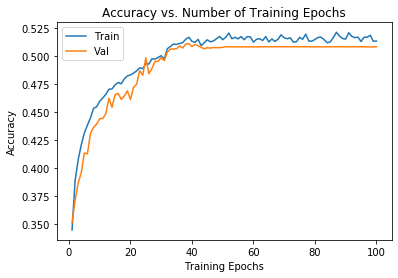

In [18]:
NUM_EPOCHS = 100
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(model, 
                                              dataloaders_dict, 
                                              criterion, 
                                              optimizer_ft, 
                                              num_epochs=NUM_EPOCHS,
                                              lr_scheduler=scheduler_ft,
                                              train_phase_name='train_corruption'
                                             )
    save_model(model, path='mahal_llr_2_fine.pt')
    save_history(train_hist, val_hist, 'mahal_llr_2_train_hist_fine.pickle', 'mahal_llr_2_val_hist_fine.pickle')
else:
    load_model(model, path='mahal_llr_2_fine.pt')
    train_hist, val_hist = load_history('mahal_llr_2_train_hist_fine.pickle', 'mahal_llr_2_val_hist_fine.pickle')

plot_training_hist(train_hist, val_hist)

In [19]:
print("Model accuracy:", evaluate_model(model, dataloaders_dict['val'])) 


Model accuracy: 0.5111


# Train Mahalanobis Distance functions

In [20]:
model1 = create_model("vgg16")
model1 = model1.to(device)
load_model(model1, path="mahal_llr_1_fine.pt")

model2 = create_model("vgg16")
model2 = model2.to(device)
load_model(model2, path="mahal_llr_2_fine.pt")

In [21]:
def penultimate_forward_vgg16(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    
    # Break up self.classifier
    penultimate = model.classifier[:5](x)
    out = model.classifier[5:](penultimate)
    return out, penultimate

# Bind a function to the model to extract penultimate features
model1.penultimate_forward = penultimate_forward_vgg16.__get__(model1)
model2.penultimate_forward = penultimate_forward_vgg16.__get__(model2)

In [22]:
# Get penultimate features, outputs, and labels from datasets set
if TRAIN:
    for model, result_file in [(model1, 'mahal_llr_1.h5'), (model2, 'mahal_llr_2.h5')]:
        model.eval()

        for dataset in ['train_no_aug', 'val', 'ood', 'svhn', 'imagenet_resize']:
            softmax_outputs = []
            mahalanobis_features = []
            labels_out = []  

            for inputs, labels in tqdm(dataloaders_dict[dataset], total=len(dataloaders_dict[dataset]), desc=dataset):
                outputs, features = model.penultimate_forward(inputs.to(device))

                softmax_outputs.append(outputs.cpu().detach().numpy())
                mahalanobis_features.append(features.cpu().detach().numpy())
                labels_out.append(labels.cpu().detach().numpy())

            # Save outputs to disk
            with h5py.File(result_file, "a") as f:
                if dataset in f.keys():
                    del f[dataset]

                g = f.create_group(dataset)
                g.create_dataset("softmax_outputs", data=np.concatenate(softmax_outputs, axis=0))
                g.create_dataset("mahalanobis_features", data=np.concatenate(mahalanobis_features, axis=0))
                g.create_dataset("labels", data=np.concatenate(labels_out, axis=0))

In [23]:
class Mahal_Dist(object):
    def __init__(self, gt_features=None, gt_labels=None):
        super().__init__()
        
        if gt_features is not None and gt_labels is not None:
            self.fit(gt_features, gt_labels)
        
    def fit(self, gt_features, gt_labels):
        """Fit parameters used for Mahalanobis distance."""
        self.labels = sorted(np.unique(gt_labels).astype(np.int))
        
        mahal_means = []
        print("Calculating mahal mean")
        for l in self.labels:
            mask = gt_labels == l
            mahal_means.append(gt_features[mask].mean(axis=0))#, dtype=np.float16))
            
        self.mahal_means = np.array(mahal_means)

        x = gt_features.copy()
        print("Calculating mahal cov")
        for i, l in enumerate(self.labels):
            mask = gt_labels == l
            x[mask] -= self.mahal_means[i]

        self.mahal_cov = np.dot(x.T, x) / len(gt_features)
        print("Inverting")
        self.inv_mahal_cov = np.linalg.inv(self.mahal_cov + np.eye(len(self.mahal_cov)) * 1e-10)
        
    def __call__(self, features):
        """Return the distance based confidence score to each 
            of the means."""
        x =  -self.mahal_means + features
        m_x = np.diag(np.dot(np.dot(x, self.inv_mahal_cov), x.T))
        return np.array(m_x)
    
    def label_dist(self, features):
        """Return the label of the closest mean and the 
            mahalanobis distance to it."""
        m_x = self(features)
        min_i = np.argmin(m_x, axis=0)
        return np.array([self.labels[min_i], m_x[min_i]])
    
    def label(self, features):
        """Return the label of the closest mean."""
        return self.labels[np.argmin(self(features), axis=0)]
    
    def dist(self, features):
        """Return the dist of the closest mean."""
        return np.min(self(features), axis=0)
    
    def save(self, fname='mahal_distance.h5'):
        """Save precomputed Mahal_Dist object with all means and covariance matrix."""
        with h5py.File(fname, 'a') as f:
            # Remove old data if exists
            if "mahal_distance" in f.keys():
                del f['mahal_distance']
                
            # Store the new data
            g = f.create_group("mahal_distance")
            g.create_dataset("means", data=self.mahal_means)
            g.create_dataset("cov", data=self.mahal_cov)
            g.create_dataset("inv_cov", data=self.inv_mahal_cov)
            g.create_dataset("labels", data=self.inv_mahal_cov)
            
    @classmethod
    def load(cls, fname='mahal_distance.h5'):
        """Load precomputed Mahal_Dist object with all means and covariance matrix."""
        inst = cls()
        
        with h5py.File(fname, 'r') as f:
            inst.labels = f['mahal_distance/labels'][()]
            inst.mahal_means = f['mahal_distance/means'][()]
            inst.mahal_cov = f['mahal_distance/cov'][()]
            inst.inv_mahal_cov = f['mahal_distance/inv_cov'][()]
        
        return inst

In [24]:
md = []
for i, result_file in enumerate(['mahal_llr_1.h5', 'mahal_llr_2.h5']): 
    if TRAIN:
        with h5py.File(result_file, "r") as f:
            print(f.keys())
            mahalanobis_features_train = f['train_no_aug/mahalanobis_features'][()]
            labels_train = f['train_no_aug/labels'][()]

        md.append(Mahal_Dist())
        md[-1].fit(mahalanobis_features_train, labels_train)
        md[-1].save(result_file)
    else:
        md.append(Mahal_Dist.load(result_file))

<KeysViewHDF5 ['imagenet_resize', 'mahal_distance', 'ood', 'svhn', 'train_no_aug', 'val']>
Calculating mahal mean
Calculating mahal cov
Inverting
<KeysViewHDF5 ['imagenet_resize', 'mahal_distance', 'ood', 'svhn', 'train_no_aug', 'val']>
Calculating mahal mean
Calculating mahal cov
Inverting


# Extract FG, BG, OOD Softmax predictions and Mahal features

In [25]:
for i, result_file in enumerate(['mahal_llr_1.h5', 'mahal_llr_2.h5']): 
    if TRAIN:
        for dataset in ['val', 'ood', 'svhn', 'imagenet_resize']:
            with h5py.File(result_file, 'r') as f:
                g = f[dataset]
                labels = g['labels'][()]
                features = g['mahalanobis_features'][()]
                outputs = g['softmax_outputs'][()]    

            mahalanobis_label_dist = []
            for feat in tqdm(features, total=len(features)):
                mahalanobis_label_dist.append(md[i].label_dist(feat))

            # Get gt_labels, predicted labels, distance to nearest mean
            mahalanobis_labels = [x[0] for x in mahalanobis_label_dist]
            mahalanobis_dist = [x[1] for x in mahalanobis_label_dist]

            with h5py.File(result_file, 'a') as f:
                g = f[dataset]          
                g.create_dataset('mahalanobis_labels', data=mahalanobis_labels)
                g.create_dataset('mahalanobis_dists', data=mahalanobis_dist)    

In [26]:
for i, result_file in enumerate(['mahal_llr_1.h5', 'mahal_llr_2.h5']): 
    with h5py.File(result_file, 'r') as f:
        g = f['val']
        labels_val = g['labels'][()]
        mahalanobis_labels_val = g['mahalanobis_labels'][()]
        mahalanobis_dist_val = g['mahalanobis_dists'][()]

    correct = np.sum((mahalanobis_labels_val == labels_val).astype(np.int))
    print("%d%% of val data classified correctly with mahalanobis distance" % (correct / len(labels_val) * 100))

82% of val data classified correctly with mahalanobis distance
69% of val data classified correctly with mahalanobis distance


### Compare naive Mahalanobis distance to LLR Mahalanobis

In [27]:
for i, result_file in enumerate(['mahal_llr_1.h5', 'mahal_llr_2.h5']): 
    print(result_file)
    if TRAIN:
        for dataset in ['val', 'ood', 'svhn', 'imagenet_resize']:
            print(dataset)
            with h5py.File(result_file, 'r') as f:
                g = f[dataset]
                labels = g['labels'][()]
                features = g['mahalanobis_features'][()]
                outputs = g['softmax_outputs'][()]    

            # Get dists to each class
            mahalanobis_dists = []
            for feat in tqdm(features, total=len(features)):
                mahalanobis_dists.append(md[i](feat))

            with h5py.File(result_file, 'a') as f:
                g = f[dataset]          
                g.create_dataset('mahalanobis_all_dists', data=mahalanobis_dists) 

mahal_llr_1.h5
val



ood



svhn



imagenet_resize



mahal_llr_2.h5
val



ood



svhn



imagenet_resize


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# CIFAR 100 OOD

In [29]:
OOD_SET = 'ood'

def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / np.expand_dims(e_x.sum(axis=axis), axis)


def llr(d1, d2):
    ii = d1.argmin(axis=1)
    return np.diag(d1.take(ii, axis=1)) - np.diag(d2.take(ii, axis=1))

with h5py.File('mahal_llr_1.h5', 'r') as f:          
    d1_val = f['val/mahalanobis_all_dists'][()]
    d1_ood = f[f'{OOD_SET}/mahalanobis_all_dists'][()]
    
with h5py.File('mahal_llr_2.h5', 'r') as f:          
    d2_val = f['val/mahalanobis_all_dists'][()]
    d2_ood = f[f'{OOD_SET}/mahalanobis_all_dists'][()]
    
with h5py.File('mahal_llr_1.h5', 'r') as f:          
    labels_val = f['val/labels'][()]
    labels_ood = f[f'{OOD_SET}/labels'][()]
    
    softmax_val = softmax(f['val/softmax_outputs'][()])
    softmax_ood = softmax(f[f'{OOD_SET}/softmax_outputs'][()])
    
llr_val = llr(d1_val, d2_val)
llr_ood = llr(d1_ood, d2_ood)

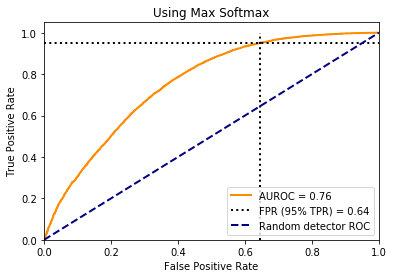

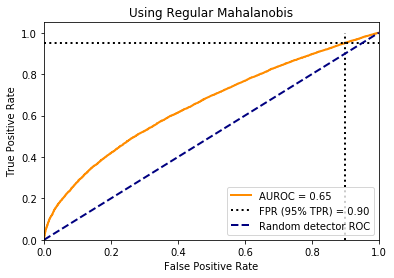

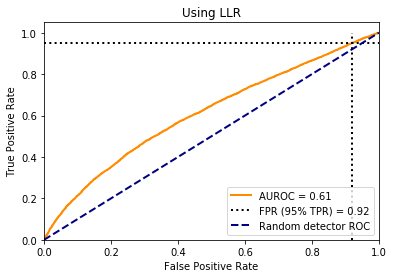

In [30]:
from ood_metrics import plot_roc

llr_scores = abs(np.concatenate([llr_val, llr_ood], axis=0))
labels = np.concatenate([labels_val, labels_ood], axis=0)
labels[labels < 10] = 0
labels[labels >= 10] = 1

naive_scores = np.concatenate([d1_val.min(axis=1), d1_ood.min(axis=1)], axis=0)
softmax_scores = np.concatenate([softmax_val.max(axis=1), softmax_ood.max(axis=1)], axis=0)

plot_roc(-softmax_scores, labels, title="Using Max Softmax")
plot_roc(naive_scores, labels, title="Using Regular Mahalanobis")
plot_roc(llr_scores, labels, title="Using LLR")

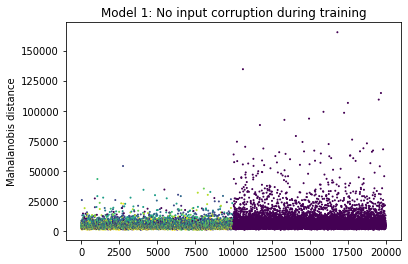

In [31]:
labels = np.concatenate([labels_val, labels_ood], axis=0)
labels[labels >= 10] = 0

plt.scatter(range(len(naive_scores)), naive_scores, c=labels, s=1)
plt.title("Model 1: No input corruption during training")
plt.ylabel("Mahalanobis distance")
plt.show()

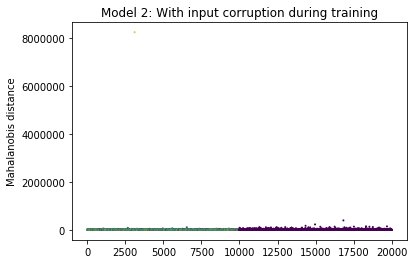

In [32]:
other_scores = np.concatenate([d2_val.min(axis=1), d2_ood.min(axis=1)], axis=0)
plt.scatter(range(len(other_scores)), other_scores, c=labels, s=1)
plt.title("Model 2: With input corruption during training")
plt.ylabel("Mahalanobis distance")
plt.show()

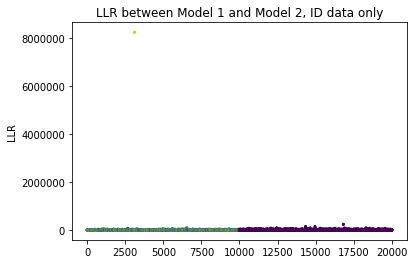

In [33]:
scatter = plt.scatter(range(len(llr_scores)), llr_scores, c=labels, s=5)
plt.title("LLR between Model 1 and Model 2, ID data only")
plt.ylabel("LLR")
plt.show()

# SVHN OOD

In [34]:
OOD_SET = 'svhn'

with h5py.File('mahal_llr_1.h5', 'r') as f:          
    d1_val = f['val/mahalanobis_all_dists'][()]
    d1_ood = f[f'{OOD_SET}/mahalanobis_all_dists'][()]
    
with h5py.File('mahal_llr_2.h5', 'r') as f:          
    d2_val = f['val/mahalanobis_all_dists'][()]
    d2_ood = f[f'{OOD_SET}/mahalanobis_all_dists'][()]
    
with h5py.File('mahal_llr_1.h5', 'r') as f:          
    labels_val = f['val/labels'][()]
    labels_ood = f[f'{OOD_SET}/labels'][()]
    
    softmax_val = softmax(f['val/softmax_outputs'][()])
    softmax_ood = softmax(f[f'{OOD_SET}/softmax_outputs'][()])
    
llr_val = llr(d1_val, d2_val)
llr_ood = llr(d1_ood, d2_ood)

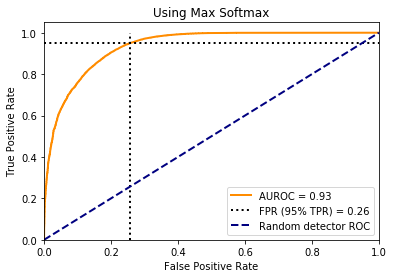

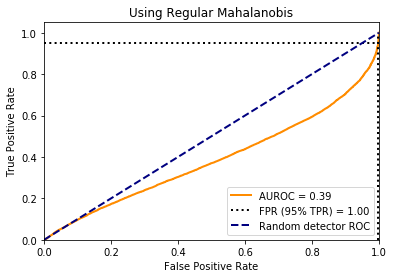

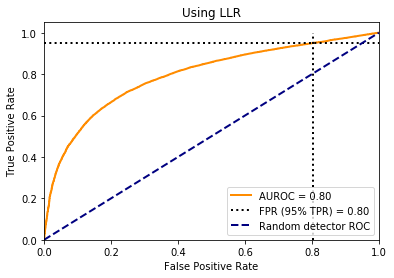

In [35]:
from ood_metrics import plot_roc

llr_scores = abs(np.concatenate([llr_val, llr_ood], axis=0))
labels = np.concatenate([labels_val, labels_ood], axis=0)
labels[labels < 10] = 0
labels[labels >= 10] = 1

naive_scores = np.concatenate([d1_val.min(axis=1), d1_ood.min(axis=1)], axis=0)
softmax_scores = np.concatenate([softmax_val.max(axis=1), softmax_ood.max(axis=1)], axis=0)

plot_roc(-softmax_scores, labels, title="Using Max Softmax")
plot_roc(naive_scores, labels, title="Using Regular Mahalanobis")
plot_roc(llr_scores, labels, title="Using LLR")

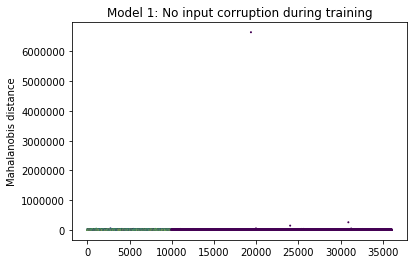

In [36]:
labels = np.concatenate([labels_val, labels_ood], axis=0)
labels[labels >= 10] = 0

plt.scatter(range(len(naive_scores)), naive_scores, c=labels, s=1)
plt.title("Model 1: No input corruption during training")
plt.ylabel("Mahalanobis distance")
plt.show()

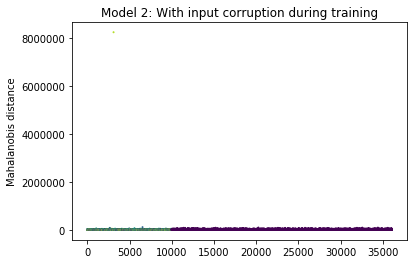

In [37]:
other_scores = np.concatenate([d2_val.min(axis=1), d2_ood.min(axis=1)], axis=0)
plt.scatter(range(len(other_scores)), other_scores, c=labels, s=1)
plt.title("Model 2: With input corruption during training")
plt.ylabel("Mahalanobis distance")
plt.show()

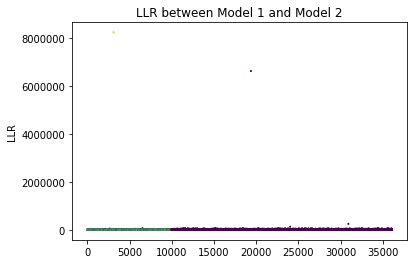

In [38]:
plt.scatter(range(len(llr_scores)), llr_scores, c=labels, s=1)
plt.title("LLR between Model 1 and Model 2")
plt.ylabel("LLR")
plt.show()

# Imagenet Resize OOD

In [39]:
OOD_SET = 'imagenet_resize'

with h5py.File('mahal_llr_1.h5', 'r') as f:          
    d1_val = f['val/mahalanobis_all_dists'][()]
    d1_ood = f[f'{OOD_SET}/mahalanobis_all_dists'][()]
    
with h5py.File('mahal_llr_2.h5', 'r') as f:          
    d2_val = f['val/mahalanobis_all_dists'][()]
    d2_ood = f[f'{OOD_SET}/mahalanobis_all_dists'][()]
    
with h5py.File('mahal_llr_1.h5', 'r') as f:          
    labels_val = f['val/labels'][()]
    labels_ood = f[f'{OOD_SET}/labels'][()]
    
    softmax_val = softmax(f['val/softmax_outputs'][()])
    softmax_ood = softmax(f[f'{OOD_SET}/softmax_outputs'][()])
    
llr_val = llr(d1_val, d2_val)
llr_ood = llr(d1_ood, d2_ood)

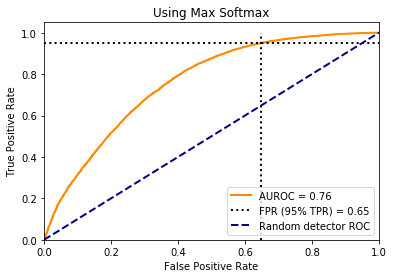

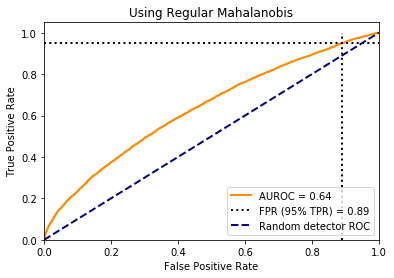

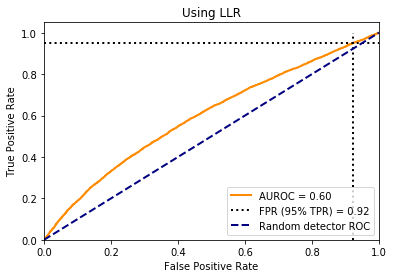

In [40]:
from ood_metrics import plot_roc

llr_scores = abs(np.concatenate([llr_val, llr_ood], axis=0))
labels = np.concatenate([labels_val, labels_ood], axis=0)
labels[labels < 10] = 0
labels[labels >= 10] = 1

naive_scores = np.concatenate([d1_val.min(axis=1), d1_ood.min(axis=1)], axis=0)
softmax_scores = np.concatenate([softmax_val.max(axis=1), softmax_ood.max(axis=1)], axis=0)

plot_roc(-softmax_scores, labels, title="Using Max Softmax")
plot_roc(naive_scores, labels, title="Using Regular Mahalanobis")
plot_roc(llr_scores, labels, title="Using LLR")

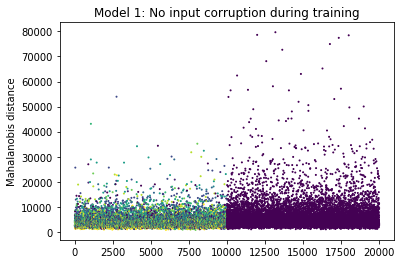

In [41]:
labels = np.concatenate([labels_val, labels_ood], axis=0)
labels[labels >= 10] = 0

plt.scatter(range(len(naive_scores)), naive_scores, c=labels, s=1)
plt.title("Model 1: No input corruption during training")
plt.ylabel("Mahalanobis distance")
plt.show()

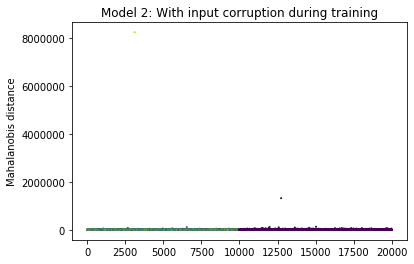

In [42]:
other_scores = np.concatenate([d2_val.min(axis=1), d2_ood.min(axis=1)], axis=0)
plt.scatter(range(len(other_scores)), other_scores, c=labels, s=1)
plt.title("Model 2: With input corruption during training")
plt.ylabel("Mahalanobis distance")
plt.show()

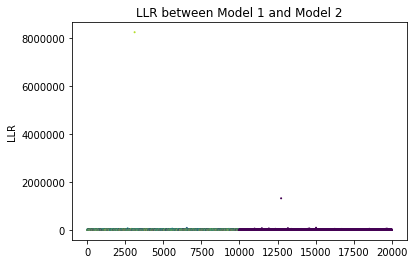

In [43]:
plt.scatter(range(len(llr_scores)), llr_scores, c=labels, s=1)
plt.title("LLR between Model 1 and Model 2")
plt.ylabel("LLR")
plt.show()